In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
! pip install scikit-optimize
# report scikit-optimize version number
import skopt
print('skopt %s' % skopt.__version__)
from skopt.space import Integer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LayerNormalization
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras import backend as K
import argparse

skopt 0.10.1


In [2]:
#data from kaggle dataset: "Prediction of music genre"
data1 = pd.read_csv("~/Downloads/music_genre.csv")
#data from kaggle data set: "Spotify Tracks Dataset"
data2 = pd.read_csv("~/Downloads/dataset.csv")

<h1>Data 1</h1>

<h2> Data 1 Cleaning </h2>

In [3]:
#because all the column values are none values, drop those rows
before_drop_na = len(data1)
data1 = data1.dropna()
after_drop_na = len(data1)
print("number of data dropped:", before_drop_na-after_drop_na)

number of data dropped: 5


In [4]:
#make key, mode into One Hot encoding
#music_genre into label encoding
onehot =OneHotEncoder(sparse=False)
onehot.fit(data1[['key', 'mode']])
onehotencoded = onehot.transform(data1[['key', 'mode']])
categorical_columns = [f'{col}_{cat}' for i, col in enumerate(data1[['key', 'mode']].columns) for cat in onehot.categories_[i]]
onehotdf = pd.DataFrame(onehotencoded, columns=categorical_columns)
data1 = pd.concat([data1.reset_index(), onehotdf.reset_index()], axis=1)
labelencoder = LabelEncoder()
data1['key_num'] = labelencoder.fit_transform(data1['key'])
data1['mode_num'] = labelencoder.fit_transform(data1['mode'])
data1['music_genre_num'] = labelencoder.fit_transform(data1['music_genre'])
data1

/Users/mkobayashi/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,index,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,...,key_E,key_F,key_F#,key_G,key_G#,mode_Major,mode_Minor,key_num,mode_num,music_genre_num
0,0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,5
1,1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5,1,5
2,2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,11,0,5
3,3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4,0,5
4,4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,9,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,50000,58878.0,BEXEY,GO GETTA,59.0,0.03340,0.913,-1.0,0.574,0.00000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4,0,6
49996,50001,43557.0,Roy Woods,Drama (feat. Drake),72.0,0.15700,0.709,251860.0,0.362,0.00000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,0,6
49997,50002,39767.0,Berner,Lovin' Me (feat. Smiggz),51.0,0.00597,0.693,189483.0,0.763,0.00000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5,0,6
49998,50003,57944.0,The-Dream,Shawty Is Da Shit,65.0,0.08310,0.782,262773.0,0.472,0.00000,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,10,1,6


In [5]:
#not including tempo
data1_edit = data1.drop(columns = ["index", "instance_id", "artist_name", "track_name", "key", "mode", "tempo", "obtained_date", "music_genre", "key_num", "mode_num", "music_genre_num"])
features = data1_edit.columns
len(features)

24

<h2>ANN Data 1</h2>

<h3>Baseline using SGD</h3>

In [6]:
# train 80%, val 20%, test 20%
X_train1b, X_test1b, y_train1b, y_test1b = train_test_split(data1[features], data1["music_genre_num"], test_size=0.2, random_state=1)


In [7]:
model1bs = Sequential()
model1bs.add(Dense(256, input_shape=(24,), activation="relu"))
model1bs.add(Dense(10, activation="softmax"))

sgd = SGD(0.01) #learning rate = 0.01
model1bs.compile(loss="sparse_categorical_crossentropy", optimizer=sgd,
	metrics=["accuracy"]) #use sparse for loss because label is integer and not vector
H1bs = model1bs.fit(X_train1b, y_train1b, validation_split=0.2,
	epochs=100, batch_size=64, shuffle=True)

Epoch 1/100
500/500 [==============================] - 1s 854us/step - loss: 404306368.0000 - accuracy: 0.1046 - val_loss: 212899424.0000 - val_accuracy: 0.1071
Epoch 2/100
500/500 [==============================] - 1s 1ms/step - loss: 73946208.0000 - accuracy: 0.1166 - val_loss: 104841632.0000 - val_accuracy: 0.1175
Epoch 3/100
500/500 [==============================] - 0s 549us/step - loss: 41723416.0000 - accuracy: 0.1168 - val_loss: 68114352.0000 - val_accuracy: 0.1139
Epoch 4/100
500/500 [==============================] - 1s 1ms/step - loss: 27993548.0000 - accuracy: 0.1114 - val_loss: 48060836.0000 - val_accuracy: 0.1135
Epoch 5/100
500/500 [==============================] - 1s 3ms/step - loss: 19696898.0000 - accuracy: 0.1088 - val_loss: 34478288.0000 - val_accuracy: 0.1157
Epoch 6/100
500/500 [==============================] - 0s 721us/step - loss: 14797222.0000 - accuracy: 0.1088 - val_loss: 25938716.0000 - val_accuracy: 0.1090
Epoch 7/100
500/500 [============================

In [8]:
print("Training Accuracy:", model1bs.evaluate(X_train1b, y_train1b))
print("Test Accuracy:", model1bs.evaluate(X_test1b, y_test1b))

1250/1250 [==============================] - 1s 384us/step - loss: 164128.1719 - accuracy: 0.1277
Training Accuracy: [164128.171875, 0.1277499943971634]
313/313 [==============================] - 0s 342us/step - loss: 2043591.8750 - accuracy: 0.1244
Test Accuracy: [2043591.875, 0.12439999729394913]


<h3>Baseline using Adam</h3>

In [9]:
model1ba = Sequential()
model1ba.add(Dense(256, input_shape=(24,), activation="relu"))
model1ba.add(Dense(10, activation="softmax"))

model1ba.compile(loss="sparse_categorical_crossentropy", optimizer="adam",
	metrics=["accuracy"]) #use sparse for loss because label is integer and not vector
H1ba = model1ba.fit(X_train1b, y_train1b, validation_split=0.2,
	epochs=100, batch_size=64, shuffle=True)

Epoch 1/100
500/500 [==============================] - 1s 759us/step - loss: 1875.1091 - accuracy: 0.1145 - val_loss: 1377.6469 - val_accuracy: 0.1241
Epoch 2/100
500/500 [==============================] - 0s 612us/step - loss: 1593.3954 - accuracy: 0.1289 - val_loss: 940.8981 - val_accuracy: 0.1277
Epoch 3/100
500/500 [==============================] - 0s 647us/step - loss: 1362.8165 - accuracy: 0.1333 - val_loss: 2172.1174 - val_accuracy: 0.1312
Epoch 4/100
500/500 [==============================] - 0s 718us/step - loss: 1220.2632 - accuracy: 0.1380 - val_loss: 1714.7274 - val_accuracy: 0.1283
Epoch 5/100
500/500 [==============================] - 0s 625us/step - loss: 1117.2815 - accuracy: 0.1414 - val_loss: 1199.4080 - val_accuracy: 0.1332
Epoch 6/100
500/500 [==============================] - 0s 729us/step - loss: 1162.1221 - accuracy: 0.1417 - val_loss: 1081.8414 - val_accuracy: 0.1359
Epoch 7/100
500/500 [==============================] - 0s 684us/step - loss: 1030.4075 - accura

In [10]:
print("Training Accuracy:", model1ba.evaluate(X_train1b, y_train1b))
print("Test Accuracy:", model1ba.evaluate(X_test1b, y_test1b))

1250/1250 [==============================] - 0s 311us/step - loss: 2.1904 - accuracy: 0.1468
Training Accuracy: [2.1904234886169434, 0.14682500064373016]
313/313 [==============================] - 0s 317us/step - loss: 2.2190 - accuracy: 0.1375
Test Accuracy: [2.219024896621704, 0.13750000298023224]


In [27]:
print(classification_report(y_test1b, np.argmax(model1ba.predict(X_test1b, 1), axis =-1)))

10000/10000 [==============================] - 18s 2ms/step
              precision    recall  f1-score   support

           0       0.44      0.02      0.04      1005
           1       0.64      0.06      0.12      1057
           2       0.52      0.05      0.08       985
           3       0.79      0.07      0.12       967
           4       0.33      0.06      0.10       969
           5       0.69      0.04      0.08      1029
           6       0.42      0.02      0.03      1012
           7       0.10      0.93      0.18       996
           8       0.36      0.06      0.10       982
           9       0.52      0.08      0.14       998

    accuracy                           0.14     10000
   macro avg       0.48      0.14      0.10     10000
weighted avg       0.48      0.14      0.10     10000



<h3>Rescale data</h3>

In [11]:
scaler1 = preprocessing.MinMaxScaler()
scaled_feat1 = scaler1.fit_transform(data1[features])

X_train2, X_test2, y_train2, y_test2 = train_test_split(scaled_feat1, data1["music_genre_num"], test_size=0.2, random_state=1)

In [12]:
model2 = Sequential()
model2.add(Dense(256, input_shape=(24,), activation="relu"))
model2.add(Dense(10, activation="softmax"))

model2.compile(loss="sparse_categorical_crossentropy", optimizer="adam",
	metrics=["accuracy"]) #use sparse for loss because label is integer and not vector
H2 = model2.fit(X_train2, y_train2, validation_split=0.2,
	epochs=100, batch_size=64, shuffle=True)

Epoch 1/100
500/500 [==============================] - 1s 700us/step - loss: 1.6987 - accuracy: 0.3945 - val_loss: 1.4203 - val_accuracy: 0.4839
Epoch 2/100
500/500 [==============================] - 0s 568us/step - loss: 1.3517 - accuracy: 0.4986 - val_loss: 1.2887 - val_accuracy: 0.5214
Epoch 3/100
500/500 [==============================] - 0s 562us/step - loss: 1.2836 - accuracy: 0.5168 - val_loss: 1.2577 - val_accuracy: 0.5265
Epoch 4/100
500/500 [==============================] - 0s 569us/step - loss: 1.2564 - accuracy: 0.5277 - val_loss: 1.2326 - val_accuracy: 0.5393
Epoch 5/100
500/500 [==============================] - 0s 563us/step - loss: 1.2379 - accuracy: 0.5332 - val_loss: 1.2227 - val_accuracy: 0.5456
Epoch 6/100
500/500 [==============================] - 0s 559us/step - loss: 1.2266 - accuracy: 0.5339 - val_loss: 1.2077 - val_accuracy: 0.5470
Epoch 7/100
500/500 [==============================] - 0s 851us/step - loss: 1.2161 - accuracy: 0.5373 - val_loss: 1.2060 - val_ac

In [13]:
print("Training Accuracy:", model2.evaluate(X_train2, y_train2))
print("Test Accuracy:", model2.evaluate(X_test2, y_test2))

1250/1250 [==============================] - 1s 357us/step - loss: 1.0301 - accuracy: 0.6057
Training Accuracy: [1.0301198959350586, 0.605650007724762]
313/313 [==============================] - 0s 355us/step - loss: 1.0993 - accuracy: 0.5726
Test Accuracy: [1.0992827415466309, 0.5726000070571899]


<h3>add normalization layers (layer norm, batch norm), skip connection
stay under 5 layers</h3>

In [14]:
model3 = Sequential()
model3.add(Dense(256, input_shape=(24,), activation="relu"))
model3.add(Dense(128, activation="relu"))
#LayerNormalization()
model3.add(Dense(10, activation="softmax"))

model3.compile(loss="sparse_categorical_crossentropy", optimizer="adam",
	metrics=["accuracy"]) #use sparse for loss because label is integer and not vector
H3 = model3.fit(X_train2, y_train2, validation_split=0.2,
	epochs=100, batch_size=64, shuffle=True)

Epoch 1/100
500/500 [==============================] - 1s 1ms/step - loss: 1.4903 - accuracy: 0.4454 - val_loss: 1.2588 - val_accuracy: 0.5173
Epoch 2/100
500/500 [==============================] - 0s 825us/step - loss: 1.2580 - accuracy: 0.5199 - val_loss: 1.2136 - val_accuracy: 0.5328
Epoch 3/100
500/500 [==============================] - 0s 816us/step - loss: 1.2216 - accuracy: 0.5349 - val_loss: 1.2015 - val_accuracy: 0.5506
Epoch 4/100
500/500 [==============================] - 0s 823us/step - loss: 1.2028 - accuracy: 0.5403 - val_loss: 1.1820 - val_accuracy: 0.5480
Epoch 5/100
500/500 [==============================] - 0s 819us/step - loss: 1.1888 - accuracy: 0.5454 - val_loss: 1.1835 - val_accuracy: 0.5514
Epoch 6/100
500/500 [==============================] - 0s 849us/step - loss: 1.1772 - accuracy: 0.5483 - val_loss: 1.1814 - val_accuracy: 0.5408
Epoch 7/100
500/500 [==============================] - 0s 821us/step - loss: 1.1665 - accuracy: 0.5493 - val_loss: 1.1541 - val_accu

In [15]:
print("Training Accuracy:", model3.evaluate(X_train2, y_train2))
print("Test Accuracy:", model3.evaluate(X_test2, y_test2))

1250/1250 [==============================] - 1s 684us/step - loss: 0.8961 - accuracy: 0.6531
Training Accuracy: [0.8961120843887329, 0.6530500054359436]
313/313 [==============================] - 0s 551us/step - loss: 1.1903 - accuracy: 0.5447
Test Accuracy: [1.19027578830719, 0.544700026512146]


In [16]:
model4 = Sequential()
model4.add(Dense(128, input_shape=(24,), activation="relu"))
model4.add(Dense(64, activation="relu"))
#LayerNormalization()
model4.add(Dense(10, activation="softmax"))

model4.compile(loss="sparse_categorical_crossentropy", optimizer="adam",
	metrics=["accuracy"]) #use sparse for loss because label is integer and not vector
H4 = model4.fit(X_train2, y_train2, validation_split=0.2,
	epochs=100, batch_size=64, shuffle=True)

Epoch 1/100


500/500 [==============================] - 1s 915us/step - loss: 1.5763 - accuracy: 0.4188 - val_loss: 1.2899 - val_accuracy: 0.5179
Epoch 2/100
500/500 [==============================] - 0s 762us/step - loss: 1.2782 - accuracy: 0.5127 - val_loss: 1.2346 - val_accuracy: 0.5351
Epoch 3/100
500/500 [==============================] - 0s 902us/step - loss: 1.2421 - accuracy: 0.5264 - val_loss: 1.2285 - val_accuracy: 0.5244
Epoch 4/100
500/500 [==============================] - 1s 1ms/step - loss: 1.2234 - accuracy: 0.5328 - val_loss: 1.2028 - val_accuracy: 0.5395
Epoch 5/100
500/500 [==============================] - 0s 838us/step - loss: 1.2100 - accuracy: 0.5360 - val_loss: 1.1976 - val_accuracy: 0.5456
Epoch 6/100
500/500 [==============================] - 1s 1ms/step - loss: 1.1960 - accuracy: 0.5427 - val_loss: 1.1987 - val_accuracy: 0.5386
Epoch 7/100
500/500 [==============================] - 1s 1ms/step - loss: 1.1855 - accuracy: 0.5465 - val_loss: 1.1774 - val_accuracy: 0.5525
Epo

In [17]:
print("Training Accuracy:", model4.evaluate(X_train2, y_train2))
print("Test Accuracy:", model4.evaluate(X_test2, y_test2))

1250/1250 [==============================] - 1s 611us/step - loss: 0.9811 - accuracy: 0.6152
Training Accuracy: [0.9810532331466675, 0.6151750087738037]
313/313 [==============================] - 0s 393us/step - loss: 1.0956 - accuracy: 0.5724
Test Accuracy: [1.0956217050552368, 0.5723999738693237]


In [25]:
model5 = Sequential()
model5.add(Dense(128, input_shape=(24,), activation="relu"))
model5.add(Dense(64, activation="relu"))
model5.add(Dense(32, activation="relu"))

model5.add(Dense(10, activation="softmax"))

model5.compile(loss="sparse_categorical_crossentropy", optimizer="adam",
	metrics=["accuracy"]) #use sparse for loss because label is integer and not vector
H5 = model5.fit(X_train2, y_train2, validation_split=0.2,
	epochs=100, batch_size=64, shuffle=True)

Epoch 1/100
500/500 [==============================] - 1s 2ms/step - loss: 1.5484 - accuracy: 0.4237 - val_loss: 1.2858 - val_accuracy: 0.5164
Epoch 2/100
500/500 [==============================] - 1s 1ms/step - loss: 1.2706 - accuracy: 0.5170 - val_loss: 1.2293 - val_accuracy: 0.5288
Epoch 3/100
500/500 [==============================] - 1s 1ms/step - loss: 1.2372 - accuracy: 0.5284 - val_loss: 1.2070 - val_accuracy: 0.5430
Epoch 4/100
500/500 [==============================] - 1s 2ms/step - loss: 1.2160 - accuracy: 0.5359 - val_loss: 1.1974 - val_accuracy: 0.5435
Epoch 5/100
500/500 [==============================] - 1s 2ms/step - loss: 1.2007 - accuracy: 0.5392 - val_loss: 1.1889 - val_accuracy: 0.5497
Epoch 6/100
500/500 [==============================] - 1s 1ms/step - loss: 1.1859 - accuracy: 0.5456 - val_loss: 1.1704 - val_accuracy: 0.5561
Epoch 7/100
500/500 [==============================] - 1s 2ms/step - loss: 1.1748 - accuracy: 0.5461 - val_loss: 1.1588 - val_accuracy: 0.5577

In [26]:
print("Training Accuracy:", model5.evaluate(X_train2, y_train2))
print("Test Accuracy:", model5.evaluate(X_test2, y_test2))

1250/1250 [==============================] - 1s 558us/step - loss: 0.9623 - accuracy: 0.6229
Training Accuracy: [0.9622724652290344, 0.6228500008583069]
313/313 [==============================] - 1s 2ms/step - loss: 1.1161 - accuracy: 0.5654
Test Accuracy: [1.1161466836929321, 0.5654000043869019]


In [28]:
print(classification_report(y_test2, np.argmax(model5.predict(X_test2, 1), axis =-1)))

10000/10000 [==============================] - 27s 3ms/step
              precision    recall  f1-score   support

           0       0.44      0.36      0.39      1005
           1       0.83      0.63      0.71      1057
           2       0.54      0.59      0.56       985
           3       0.82      0.83      0.83       967
           4       0.55      0.51      0.53       969
           5       0.64      0.61      0.63      1029
           6       0.46      0.38      0.42      1012
           7       0.53      0.48      0.51       996
           8       0.44      0.55      0.49       982
           9       0.49      0.73      0.58       998

    accuracy                           0.57     10000
   macro avg       0.57      0.57      0.56     10000
weighted avg       0.57      0.57      0.56     10000



<h1>NOTES</h1>

In [22]:
model1 = Sequential()
model1.add(Dense(256, input_shape=(12,), activation="sigmoid"))
model1.add(Dense(128, activation="sigmoid"))
model1.add(Dense(10, activation="softmax")) #10 corresponding to the 10 genres

sgd = SGD(0.01) #learning rate = 0.01
model1.compile(loss="sparse_categorical_crossentropy", optimizer=sgd,
	metrics=["accuracy"]) #use sparse for loss because label is integer and not vector
H1 = model1.fit(X_train1b, y_train1b, validation_data=(X_val1b, y_val1b),
	epochs=100, batch_size=128)

NameError: name 'X_val1b' is not defined

In [ ]:
print("Training Accuracy:", H1.history["accuracy"][-1])
print("Validation Accuracy:", H1.history["val_accuracy"][-1])

Training Accuracy: 0.12076666951179504
Validation Accuracy: 0.12240000069141388


using adam as optimizer instead of sgd

In [ ]:
model2 = Sequential()
model2.add(Dense(256, input_shape=(12,), activation="sigmoid"))
model2.add(Dense(128, activation="sigmoid"))
model2.add(Dense(10, activation="softmax")) #10 corresponding to the 10 genres

model2.compile(loss="sparse_categorical_crossentropy", optimizer="adam",
	metrics=["accuracy"]) #use sparse for loss because label is integer and not vector
H2 = model2.fit(X_train1b, y_train1b, validation_data=(X_val1b, y_val1b),
	epochs=100, batch_size=128)

Epoch 1/100
235/235 [==============================] - 1s 2ms/step - loss: 2.2839 - accuracy: 0.1167 - val_loss: 2.2693 - val_accuracy: 0.1238
Epoch 2/100
235/235 [==============================] - 0s 1ms/step - loss: 2.2555 - accuracy: 0.1214 - val_loss: 2.2500 - val_accuracy: 0.1199
Epoch 3/100
235/235 [==============================] - 0s 1ms/step - loss: 2.2467 - accuracy: 0.1241 - val_loss: 2.2401 - val_accuracy: 0.1307
Epoch 4/100
235/235 [==============================] - 0s 2ms/step - loss: 2.2398 - accuracy: 0.1237 - val_loss: 2.2412 - val_accuracy: 0.1246
Epoch 5/100
235/235 [==============================] - 0s 1ms/step - loss: 2.2357 - accuracy: 0.1264 - val_loss: 2.2385 - val_accuracy: 0.1258
Epoch 6/100
235/235 [==============================] - 0s 1ms/step - loss: 2.2334 - accuracy: 0.1293 - val_loss: 2.2324 - val_accuracy: 0.1345
Epoch 7/100
235/235 [==============================] - 0s 1ms/step - loss: 2.2298 - accuracy: 0.1305 - val_loss: 2.2321 - val_accuracy: 0.1275

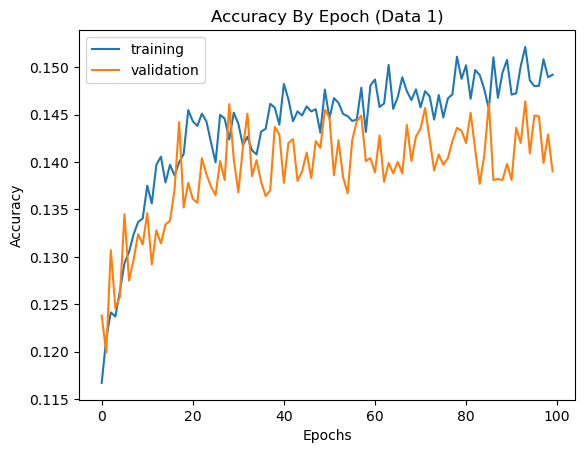

In [ ]:
plt.plot(range(len(H2.history["accuracy"])), H2.history["accuracy"], label = "training")
plt.plot(range(len(H2.history["val_accuracy"])), H2.history["val_accuracy"], label = "validation")
plt.title("Accuracy By Epoch (Data 1)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

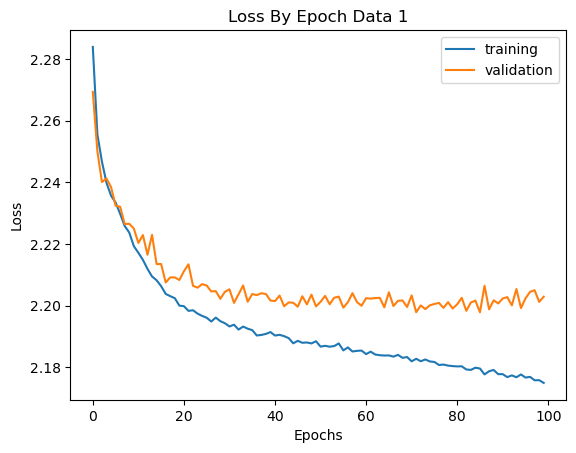

In [ ]:
plt.plot(range(len(H2.history["loss"])), H2.history["loss"], label = "training")
plt.plot(range(len(H2.history["val_loss"])), H2.history["val_loss"], label = "validation")
plt.title("Loss By Epoch Data 1")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Rescale Data

In [ ]:
scaler1 = preprocessing.MinMaxScaler()
scaled_feat1 = scaler1.fit_transform(data1[features])

X_train2, X_test2, y_train2, y_test2 = train_test_split(scaled_feat1, data1["music_genre_num"], test_size=0.2, random_state=1)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=0.25, random_state=1)

In [ ]:
model3 = Sequential()
model3.add(Dense(256, input_shape=(12,), activation="sigmoid"))
model3.add(Dense(128, activation="sigmoid"))
model3.add(Dense(10, activation="softmax")) #10 corresponding to the 10 genres

model3.compile(loss="sparse_categorical_crossentropy", optimizer="adam",
	metrics=["accuracy"]) #use sparse for loss because label is integer and not vector
H3 = model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2),
	epochs=100, batch_size=128)

Epoch 1/100
235/235 [==============================] - 1s 2ms/step - loss: 2.2080 - accuracy: 0.1908 - val_loss: 2.0221 - val_accuracy: 0.2208
Epoch 2/100
235/235 [==============================] - 0s 1ms/step - loss: 1.8944 - accuracy: 0.3035 - val_loss: 1.7578 - val_accuracy: 0.3295
Epoch 3/100
235/235 [==============================] - 0s 1ms/step - loss: 1.6372 - accuracy: 0.3863 - val_loss: 1.5594 - val_accuracy: 0.3892
Epoch 4/100
235/235 [==============================] - 0s 1ms/step - loss: 1.4764 - accuracy: 0.4445 - val_loss: 1.4399 - val_accuracy: 0.4437
Epoch 5/100
235/235 [==============================] - 0s 1ms/step - loss: 1.3933 - accuracy: 0.4740 - val_loss: 1.3877 - val_accuracy: 0.4599
Epoch 6/100
235/235 [==============================] - 0s 2ms/step - loss: 1.3472 - accuracy: 0.4911 - val_loss: 1.3479 - val_accuracy: 0.4829
Epoch 7/100
235/235 [==============================] - 0s 1ms/step - loss: 1.3250 - accuracy: 0.4945 - val_loss: 1.3319 - val_accuracy: 0.4844

Change first hidden layer to linear

In [ ]:
model4 = Sequential()
model4.add(Dense(256, input_shape=(12,))) #changing first layer to linear
model4.add(Dense(128, activation="sigmoid"))
model4.add(Dense(10, activation="softmax")) #10 corresponding to the 10 genres

model4.compile(loss="sparse_categorical_crossentropy", optimizer="adam",
	metrics=["accuracy"]) #use sparse for loss because label is integer and not vector
H4 = model4.fit(X_train2, y_train2, validation_data=(X_val2, y_val2),
	epochs=100, batch_size=128)

Epoch 1/100
235/235 [==============================] - 1s 2ms/step - loss: 1.8010 - accuracy: 0.3643 - val_loss: 1.4742 - val_accuracy: 0.4592
Epoch 2/100
235/235 [==============================] - 0s 2ms/step - loss: 1.3710 - accuracy: 0.4918 - val_loss: 1.3150 - val_accuracy: 0.5155
Epoch 3/100
235/235 [==============================] - 0s 1ms/step - loss: 1.2841 - accuracy: 0.5158 - val_loss: 1.2700 - val_accuracy: 0.5175
Epoch 4/100
235/235 [==============================] - 0s 1ms/step - loss: 1.2499 - accuracy: 0.5252 - val_loss: 1.2523 - val_accuracy: 0.5283
Epoch 5/100
235/235 [==============================] - 0s 1ms/step - loss: 1.2308 - accuracy: 0.5327 - val_loss: 1.2371 - val_accuracy: 0.5309
Epoch 6/100
235/235 [==============================] - 0s 1ms/step - loss: 1.2160 - accuracy: 0.5364 - val_loss: 1.2259 - val_accuracy: 0.5307
Epoch 7/100
235/235 [==============================] - 0s 1ms/step - loss: 1.2040 - accuracy: 0.5406 - val_loss: 1.2111 - val_accuracy: 0.5383

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3da032f1-e5ab-4726-ac09-eb3d9c053730' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>